In [1]:
"""
Week 7
Q1
List: ap1, ap3, ap4
None of these dominated each other while ap2 is dominated by ap1
"""

'\nWeek 7\nList: ap1, ap3, ap4\nNone of these dominated each other while ap2 is dominated by ap1\n'

In [1]:
import random

In [2]:
# genetic algorithm search for the test coverage problem
# this is the multi-objective version of the problem

from numpy.random import randint
from numpy.random import rand
import matplotlib.pyplot as plt

import copy
class TestDatabase:
    # This class represents our test database
    # It is already implemented, no need to change it if you don't want

    def __init__(self):
        self.coverage=[]
        self.time=[]

    def get_time(self,i):
        return self.time[i]

    def get_coverage(self,i):
        return self.coverage[i]

    def get_number_of_tests(self):
        return len(self.time)

    def init_random(self,n_tests, max_time, max_code, p=0.05):
        # initialize a test database randomly
        self.coverage = []
        self.time = []

        for i in range(n_tests):
            t_time= randint(1,max_time)
            t_coverage=[]
            for i in range(1,max_code+1):
                if rand()<p:
                    t_coverage.append(i)
            self.time.append(t_time)
            self.coverage.append(t_coverage)


    def load_from_file(self,fn):
        # load test database from file with name fn
        # file format:
        #  line i represents test i as comma separated value
        #   the first value is the time to execute the test
        #   the other values are the lines covered by the test
        #  Example
        #   5, 1, 5, 7   -> A test that covers lines 1,5,7 and takes 5 seconds to run

        self.coverage = []
        self.time = []
        with open(fn,'rt') as fd:
            for line in fd.readlines():
                words=line.split(",")
                self.time.append(float(words[0]))
                self.coverage.append(list(map(lambda x: int(x), words[1:])))

    def write_to_file(self,fn):
        # write the test database to a file with name fn
        with open(fn, 'wt') as fd:
            for time, coverage in zip(self.time, self.coverage):
                fd.write(str(time))
                for i in coverage:
                    fd.write(", "+str(i))
                fd.write("\n")


# Each solution is a set of tests and has two objectives
# total execution time, to be minimized
# total program coverage, to be maximized

def objectives(x, db):
    # returns the objectives of a solution
    # this function is ready
    coverage  = set()
    total_time = 0

    for i in range(len(x)):
        if x[i] == 1:
            total_time = total_time + db.get_time(i)
            coverage = coverage.union( db.get_coverage(i))

    return (total_time, len(coverage))

def list_to_string(x):
    """
    join x to string
    :param x:
    :return:
    """
    return "".join(map(str, x))

def string_to_listofints(x):
    return [int(i) for i in x]

# fitness function
def fitness(x, db, pareto_front_rank_reverse_mapping):
    """
    return fitness based on the rank of the pareto front of x with regard to current population
    Return score of x based on its current pareto rank
    OR we could also return it based on weakness - but for now let's do current pareto rank and see how this works
    :param x:
    :param db:
    :param pareto_front_rank_reverse_mapping:
    :return:
    """
    # TODO implement a fitness function
    # You do not want to use the same fitness function as in your solution for Week 5
    # o1,o2 =objectives(x,db)
    # # This is a not a good fitness function!
    # return 1/o1+0.5*o2 # linear objective - serve it's purpose but not a good idea
    # for now return rank directly
    assert list_to_string(x) in pareto_front_rank_reverse_mapping, "Please create the mapping for {}".format(x)
    return pareto_front_rank_reverse_mapping[list_to_string(x)]

def generate_custom_distribution(scores):
    total_score = sum(scores)
    probabilities = [sc / total_score for sc in scores]
    custom_distribution = {}
    for i, probability in enumerate(probabilities):
        custom_distribution[i] = probability
    return custom_distribution

def generate_custom_distribution_max_only(scores):
    scores = np.asarray(scores)
    scores[scores == max(scores)] = 0
    return generate_custom_distribution(scores)


def randomize_integer(custom_distribution):
    # Extract the values and probabilities from the custom distribution
    values = list(custom_distribution.keys())
    probabilities = list(custom_distribution.values())

    # Generate a random value based on the custom distribution
    randomized_value = random.choices(values, probabilities)[0]

    return randomized_value


# selection
import numpy as np
def selection(population, scores):
    # TODO implement a (better) selection function
    # Your selection operator should be aware of the
    # multiple objectives and the population pareto front
    # our scores already built in via pareto rank - so we can simply use week 5 methods of choosing parents = proportional fitness still works here
    # basically the higher the rank --> more chance of getting selected etc.

    # # -- below solution keep proportional rank
    # # generate random distribution according to scores
    custom_distribution = generate_custom_distribution(scores)
    # generate random distribution with ONLY max scores population will pass on
    # aka only those in pareto_front will be chosen as parents - elitist
    # custom_distribution = generate_custom_distribution_max_only(scores)
    # # random the individual to select
    selected_idx = randomize_integer(custom_distribution)

    return population[selected_idx]

def selection_max_only(population, scores):
    custom_distribution = generate_custom_distribution_max_only(scores)
    selected_idx = randomize_integer(custom_distribution)

    return population[selected_idx]

def selection_random_baseline(population, scores):
    selection_ix = randint(len(population))
    return population[selection_ix]

# crossover two parents to create two children
def crossover(p1, p2, r_cross):
    # TODO implement a (better) crossover function
    # children are copies of parents by default
    # copied from week 5
    assert len(p1)-1 > 1, "the length of string is too short for crossover!"
    c1, c2 = p1.copy(), p2.copy() # keep the copy for no else
    if random.random() < r_cross: # crossover accepted
        # pick a point in length of children to cross over should be from index 1 till length -1
        cross_idx = random.randint(1, len(c1)-1) # note: randint is inclusive
        # crossover
        c1 = p1[:cross_idx] + p2[cross_idx:]
        c2 = p2[:cross_idx] + p1[cross_idx:]
    return [c1, c2]

# mutation operator
def mutation(bitstring, r_mut):
    # TODO implement a (better) mutation function
    # copied from week 5
    for i in range(len(bitstring)):
        if random.random() < r_mut:
            bitstring[i] = 0 if bitstring[i] == 1 else 1
    return bitstring

def pareto_domination(a,b,db):
    # Returns True if solution a dominates solution b ?

    # First objective (time) should be minimized
    # The second objective (coverage) should be maximized

    r= False
    if objectives(a,db)[0] < objectives(b,db)[0]:
        r = True
    elif  objectives(b,db)[0] < objectives(a,db)[0]:
        return False
    if objectives(a,db)[1] > objectives(b,db)[1]:
        r = True
    elif  objectives(b,db)[1] > objectives(a,db)[1]:
        return False
    return r

def pareto_front(population,db):
    # Returns the pareto front of the population

    r= set()
    for p in population:
        r.add(tuple(p))
        for i in copy.copy(r):
            if i == tuple(p):
                continue
            if pareto_domination(i,p,db):
                r.remove(tuple(p))
                break
            elif pareto_domination(p,i,db):
                r.remove(tuple(i))
    return r

def pareto_front_rank(population, db):
    """
    assign rank to population, returns rank mapping
    :param population:
    :param db:
    :return: pareto_front_rank_map AND pareto_front_rank_reverse_map
    """
    population_str_list = list(map(list_to_string, population))
    population_set = set(population_str_list)
    pareto_front_rank_lst = []
    while len(population_set) != 0:
        pareto_front_set = pareto_front([string_to_listofints(x) for x in population_set], db)
        pareto_front_set = set(map(list_to_string, pareto_front_set))
        pareto_front_rank_lst.insert(0, pareto_front_set) # append front
        population_set = population_set.difference(pareto_front_set)
    # rank-listofstrings-mapping
    pareto_front_rank_map = {i: pfs for i, pfs in enumerate(pareto_front_rank_lst)}
    # string-rank-mapping
    pareto_front_rank_reverse_map = {s: i for i, pfs in enumerate(pareto_front_rank_lst) for s in pfs }
    return pareto_front_rank_map, pareto_front_rank_reverse_map

# genetic algorithm
# This is ready, no need to change it if you don't want
# I changed it so that we use pareto front rank to calculate the score instead
def genetic_algorithm(db, fitness, n_bits, n_iter, n_pop, r_cross, r_mut, selection=selection, to_plot=False):
    # initial population of random bitstring
    population = [randint(0, 2, n_bits).tolist() for _ in range(n_pop)]

    # enumerate generations
    for gen in range(n_iter):
        # evaluate all candidates in the population
        pareto_front_rank_map, pareto_front_rank_reverse_map = pareto_front_rank(population,
                                                                                 db)
        scores = [fitness(c,db, pareto_front_rank_reverse_map) for c in population]
        # select parents
        selected = [selection(population, scores) for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
            # crossover and mutation
            for c in crossover(p1, p2, r_cross):
                # mutation
                mutation(c, r_mut)
                # store for next generation
                children.append(c)
        # replace population
        population = children

        # plot progress
        if to_plot and gen % 10 == 0:
            plot_population(gen, population,db)

    # plot final population
    if to_plot:
        plot_population(n_iter, population, db)
    return pareto_front(population,db), population

# show a plot with the population and the pareto front
def plot_population(generation,population, db):
    front=pareto_front(population, db)
    plt.scatter(list(map(lambda i: objectives(i, db)[0], population)),
                list(map(lambda i: objectives(i, db)[1], population)), color="blue")
    plt.scatter(list(map(lambda i: objectives(i, db)[0], front)),
                list(map(lambda i: objectives(i, db)[1], front)), color="red")
    plt.title("Generation "+str(generation))
    plt.xlabel("Time")
    plt.ylabel("Code Coverage")
    plt.show()


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# intialize the problem
db= TestDatabase()
db.load_from_file("problem1.txt")

# define the total iterations, you can change this
n_iter = 100
# bits: one bit per each test that may be executed
n_bits =  db.get_number_of_tests()
# define the population size, you can change this
n_pop = 100
# crossover rate, you can change this
r_cross = 0.9
# mutation rate, you can change this
r_mut = 1.0 / float(n_bits)

# perform the genetic algorithm search
# get the means and variance of each time
# loop this - each front
times_means, coverages_means = [], []
for i in range(30):
    front, population = genetic_algorithm(db, fitness, n_bits, n_iter, n_pop, r_cross, r_mut)
    fronts_objectives = list(map(lambda x: objectives(x, db), front))
    times, coverages = list(zip(*fronts_objectives))
    times_means.append(np.mean(times))
    coverages_means.append(np.mean(coverages))
import pandas as pd
report_df = pd.DataFrame(data={
    "times_means": times_means,
    "coverages_means": coverages_means,
    "run_type": ['pareto_rank_weighted']*len(times_means)
})

# compare and put that in the report.
times_means, coverages_means = [], []
for i in range(30):
    front, population = genetic_algorithm(db, fitness, n_bits, n_iter, n_pop, r_cross, r_mut,
                                          selection=selection_max_only)
    fronts_objectives = list(map(lambda x: objectives(x, db), front))
    times, coverages = list(zip(*fronts_objectives))
    times_means.append(np.mean(times))
    coverages_means.append(np.mean(coverages))
report_df2 = pd.DataFrame(data={
    "times_means": times_means,
    "coverages_means": coverages_means,
    "run_type": ['pareto_rank_max']*len(times_means)
})
report_df = report_df.append(report_df2, ignore_index=True).reset_index(drop=True)

# random baseline runs
times_means, coverages_means = [], []
for i in range(30):
    front, population = genetic_algorithm(db, fitness, n_bits, n_iter, n_pop, r_cross, r_mut,
                                          selection=selection_random_baseline)
    fronts_objectives = list(map(lambda x: objectives(x, db), front))
    times, coverages = list(zip(*fronts_objectives))
    times_means.append(np.mean(times))
    coverages_means.append(np.mean(coverages))
report_df2 = pd.DataFrame(data={
    "times_means": times_means,
    "coverages_means": coverages_means,
    "run_type": ['random_baseline']*len(times_means)
})
report_df = report_df.append(report_df2, ignore_index=True).reset_index(drop=True)

sns.boxplot(data=report_df, x="times_means", y='run_type')
plt.figure()
sns.boxplot(data=report_df, x="coverages_means", y='run_type')

KeyboardInterrupt: 

/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_14222/746271819.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report_df = report_df.append(report_df2, ignore_index=True).reset_index(drop=True)
/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_14222/746271819.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report_df = report_df.append(report_df2, ignore_index=True).reset_index(drop=True)


<AxesSubplot: xlabel='coverages_means', ylabel='run_type'>

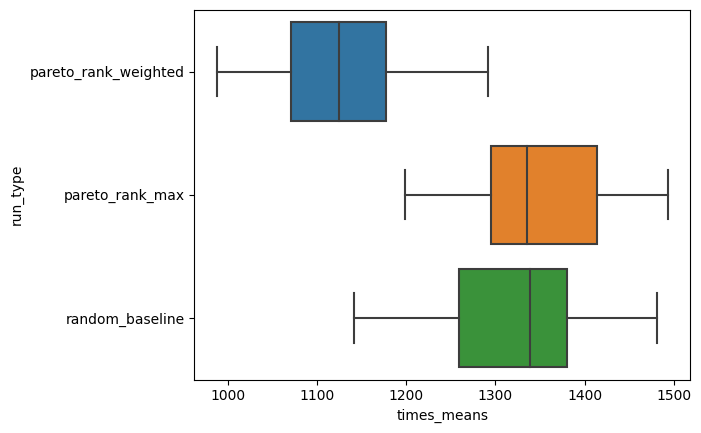

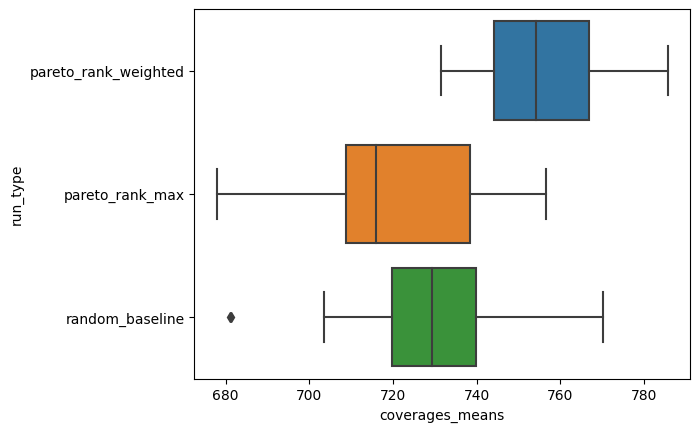

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# intialize the problem
db= TestDatabase()
db.load_from_file("problem2.txt")

# define the total iterations, you can change this
n_iter = 100
# bits: one bit per each test that may be executed
n_bits =  db.get_number_of_tests()
# define the population size, you can change this
n_pop = 100
# crossover rate, you can change this
r_cross = 0.9
# mutation rate, you can change this
r_mut = 1.0 / float(n_bits)

# perform the genetic algorithm search
# get the means and variance of each time
# loop this - each front
times_means, coverages_means = [], []
for i in range(30):
    front, population = genetic_algorithm(db, fitness, n_bits, n_iter, n_pop, r_cross, r_mut)
    fronts_objectives = list(map(lambda x: objectives(x, db), front))
    times, coverages = list(zip(*fronts_objectives))
    times_means.append(np.mean(times))
    coverages_means.append(np.mean(coverages))
import pandas as pd
report_df = pd.DataFrame(data={
    "times_means": times_means,
    "coverages_means": coverages_means,
    "run_type": ['pareto_rank_weighted']*len(times_means)
})

# compare and put that in the report.
times_means, coverages_means = [], []
for i in range(30):
    front, population = genetic_algorithm(db, fitness, n_bits, n_iter, n_pop, r_cross, r_mut,
                                          selection=selection_max_only)
    fronts_objectives = list(map(lambda x: objectives(x, db), front))
    times, coverages = list(zip(*fronts_objectives))
    times_means.append(np.mean(times))
    coverages_means.append(np.mean(coverages))
report_df2 = pd.DataFrame(data={
    "times_means": times_means,
    "coverages_means": coverages_means,
    "run_type": ['pareto_rank_max']*len(times_means)
})
report_df = report_df.append(report_df2, ignore_index=True).reset_index(drop=True)

# random baseline runs
times_means, coverages_means = [], []
for i in range(30):
    front, population = genetic_algorithm(db, fitness, n_bits, n_iter, n_pop, r_cross, r_mut,
                                          selection=selection_random_baseline)
    fronts_objectives = list(map(lambda x: objectives(x, db), front))
    times, coverages = list(zip(*fronts_objectives))
    times_means.append(np.mean(times))
    coverages_means.append(np.mean(coverages))
report_df2 = pd.DataFrame(data={
    "times_means": times_means,
    "coverages_means": coverages_means,
    "run_type": ['random_baseline']*len(times_means)
})
report_df = report_df.append(report_df2, ignore_index=True).reset_index(drop=True)

sns.boxplot(data=report_df, x="times_means", y='run_type')
plt.figure()
sns.boxplot(data=report_df, x="coverages_means", y='run_type')

/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_10549/3109934576.py:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report_df = report_df.append(report_df2, ignore_index=True).reset_index(drop=True)
/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_10549/3109934576.py:66: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  report_df = report_df.append(report_df2, ignore_index=True).reset_index(drop=True)


<AxesSubplot: xlabel='coverages_means', ylabel='run_type'>

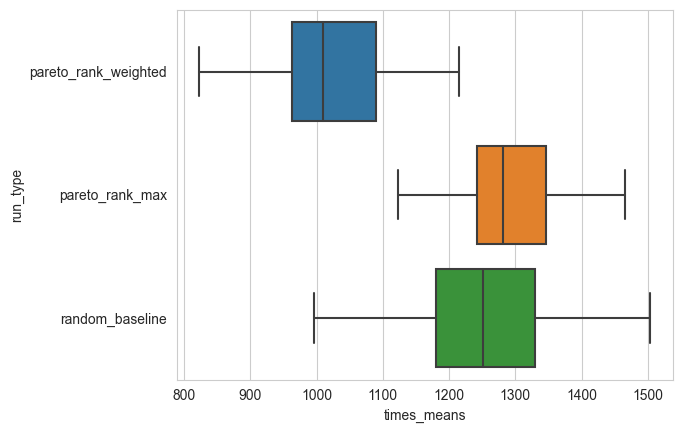

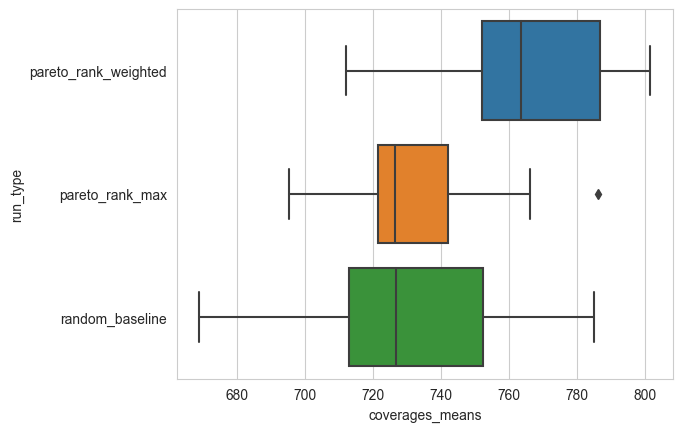

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# intialize the problem
db= TestDatabase()
db.load_from_file("problem3.txt")

# define the total iterations, you can change this
n_iter = 100
# bits: one bit per each test that may be executed
n_bits =  db.get_number_of_tests()
# define the population size, you can change this
n_pop = 100
# crossover rate, you can change this
r_cross = 0.9
# mutation rate, you can change this
r_mut = 1.0 / float(n_bits)

# perform the genetic algorithm search
# get the means and variance of each time
# loop this - each front
times_means, coverages_means = [], []
for i in range(30):
    front, population = genetic_algorithm(db, fitness, n_bits, n_iter, n_pop, r_cross, r_mut)
    fronts_objectives = list(map(lambda x: objectives(x, db), front))
    times, coverages = list(zip(*fronts_objectives))
    times_means.append(np.mean(times))
    coverages_means.append(np.mean(coverages))
import pandas as pd
report_df = pd.DataFrame(data={
    "times_means": times_means,
    "coverages_means": coverages_means,
    "run_type": ['pareto_rank_weighted']*len(times_means)
})

# compare and put that in the report.
times_means, coverages_means = [], []
for i in range(30):
    front, population = genetic_algorithm(db, fitness, n_bits, n_iter, n_pop, r_cross, r_mut,
                                          selection=selection_max_only)
    fronts_objectives = list(map(lambda x: objectives(x, db), front))
    times, coverages = list(zip(*fronts_objectives))
    times_means.append(np.mean(times))
    coverages_means.append(np.mean(coverages))
report_df2 = pd.DataFrame(data={
    "times_means": times_means,
    "coverages_means": coverages_means,
    "run_type": ['pareto_rank_max']*len(times_means)
})
report_df = report_df.append(report_df2, ignore_index=True).reset_index(drop=True)

# random baseline runs
times_means, coverages_means = [], []
for i in range(30):
    front, population = genetic_algorithm(db, fitness, n_bits, n_iter, n_pop, r_cross, r_mut,
                                          selection=selection_random_baseline)
    fronts_objectives = list(map(lambda x: objectives(x, db), front))
    times, coverages = list(zip(*fronts_objectives))
    times_means.append(np.mean(times))
    coverages_means.append(np.mean(coverages))
report_df2 = pd.DataFrame(data={
    "times_means": times_means,
    "coverages_means": coverages_means,
    "run_type": ['random_baseline']*len(times_means)
})
report_df = report_df.append(report_df2, ignore_index=True).reset_index(drop=True)

sns.boxplot(data=report_df, x="times_means", y='run_type')
plt.figure()
sns.boxplot(data=report_df, x="coverages_means", y='run_type')

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# intialize the problem
db= TestDatabase()
db.load_from_file("problem3.txt")

# define the total iterations, you can change this
n_iter = 100
# bits: one bit per each test that may be executed
n_bits =  db.get_number_of_tests()
# define the population size, you can change this
n_pop = 100
# crossover rate, you can change this
r_cross = 0.9
# mutation rate, you can change this
r_mut = 1.0 / float(n_bits)

# perform the genetic algorithm search
# get the means and variance of each time
# loop this - each front
times_means, coverages_means = [], []
front, population = genetic_algorithm(db, fitness, n_bits, n_iter, n_pop, r_cross, r_mut,
                                      selection=selection)
fronts_objectives = list(map(lambda x: objectives(x, db), front))
times, coverages = list(zip(*fronts_objectives))
times_means.append(np.mean(times))
coverages_means.append(np.mean(coverages))

In [10]:
print(front)

{(1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1), (1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0), (1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1), (1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0), (1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0), (1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0), (1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,